In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/har-dataset/Human_Activity_Recognition_Using_Smartphones_Data.csv


In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, Dropout, ReLU, Flatten, Add, Dense, Multiply,
    GlobalAveragePooling1D, Reshape
)
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
)
import time
import matplotlib.pyplot as plt
from tqdm import tqdm  # Progress bar

# Load dataset
df = pd.read_csv('/kaggle/input/har-dataset/Human_Activity_Recognition_Using_Smartphones_Data.csv')

# Encode target labels
label_encoder = LabelEncoder()
df['Activity'] = label_encoder.fit_transform(df['Activity'])

# Separate features and target
X = df.drop(columns=['Activity']).values
y = df['Activity'].values

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Feature Selection using LASSO
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_scaled, y)

# Extract absolute coefficients from the best alpha model
feature_importance = np.abs(lasso.coef_)

# Get feature names
feature_names = df.drop(columns=["Activity"]).columns

# Select top 150 features based on importance
sorted_idx = np.argsort(feature_importance)[::-1][:150]  # Select top 150 features 
selected_features = np.array(feature_names)[sorted_idx]
num_features = len(selected_features)  # Get number of selected features

# Print the number of selected features
print(f"Number of features used for model training: {num_features}")

# Select corresponding columns from scaled dataset
X_selected = X_scaled[:, sorted_idx]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Reshape for TCN input
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Define Attention Mechanism
def attention_block(inputs):
    """Attention Mechanism"""
    avg_pool = GlobalAveragePooling1D()(inputs)
    dense1 = Dense(units=inputs.shape[-1], activation="relu")(avg_pool)
    dense2 = Dense(units=inputs.shape[-1], activation="sigmoid")(dense1)
    attention = Multiply()([inputs, Reshape((1, inputs.shape[-1]))(dense2)])
    return attention

# Define TCN Residual Block with Dilated Convolutions
def residual_block(x, filters, dilation_rate):
    """TCN Residual Block"""
    conv1 = Conv1D(filters=filters, kernel_size=3, padding='causal', dilation_rate=dilation_rate)(x)
    bn1 = BatchNormalization()(conv1)
    relu1 = ReLU()(bn1)
    dropout1 = Dropout(0.3)(relu1)

    conv2 = Conv1D(filters=filters, kernel_size=3, padding='causal', dilation_rate=dilation_rate)(dropout1)
    bn2 = BatchNormalization()(conv2)
    relu2 = ReLU()(bn2)

    # Residual Connection
    res = Add()([x, relu2])
    
    return res

# Cross-validation setup
kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
best_accuracy = 0
best_model = None
best_training_time = None

# Cross-validation loop
with tqdm(total=kf.get_n_splits(), desc="Running Cross-Validation", unit="split") as pbar:
    for train_index, val_index in kf.split(X_train, y_train):
        X_tr, X_val = X_train[train_index], X_train[val_index]
        y_tr, y_val = y_train[train_index], y_train[val_index]

        # Define TCN Model
        input_layer = Input(shape=(X_train.shape[1], 1))
        
        # TCN Residual Blocks with Dilated Convolutions
        res_block1 = residual_block(input_layer, filters=64, dilation_rate=1)
        res_block2 = residual_block(res_block1, filters=64, dilation_rate=2)
        res_block3 = residual_block(res_block2, filters=64, dilation_rate=4)

        # Attention Mechanism
        attention_output = attention_block(res_block3)

        flatten = Flatten()(attention_output)
        dense1 = Dense(128, activation='relu')(flatten)
        dropout2 = Dropout(0.3)(dense1)
        output_layer = Dense(len(np.unique(y)), activation='softmax')(dropout2)

        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        # Train the model and track training time
        start_train_time = time.time()
        history = model.fit(X_tr, y_tr, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=0)
        training_time = time.time() - start_train_time

        # Evaluate the model
        val_accuracy = model.evaluate(X_val, y_val, verbose=0)[1]
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model = model
            best_training_time = training_time

        pbar.update(1)  # Update progress bar

# Evaluate the best model
start_time = time.time()
y_pred_prob = best_model.predict(X_test)
inference_time = time.time() - start_time
y_pred = np.argmax(y_pred_prob, axis=1)

# Metrics Calculation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(tf.keras.utils.to_categorical(y_test), y_pred_prob, multi_class='ovr')

# Specificity Calculation
specificity = np.mean(np.diag(cm) / np.sum(cm, axis=1))

# Print Metrics
print(f"Features used for model training: {num_features}")
print(f"Model Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Training Time (Best Model): {best_training_time:.2f} seconds")
print(f"Inference Time: {inference_time:.2f} seconds")


Number of features used for model training: 150


Running Cross-Validation: 100%|██████████| 2/2 [01:09<00:00, 34.63s/split]


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
Features used for model training: 150
Model Test Accuracy: 0.9782
Precision: 0.9783
Recall (Sensitivity): 0.9782
Specificity: 0.9780
F1-Score: 0.9781
ROC AUC: 0.9994
Training Time (Best Model): 32.05 seconds
Inference Time: 2.22 seconds


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
157/157 ━━━━━

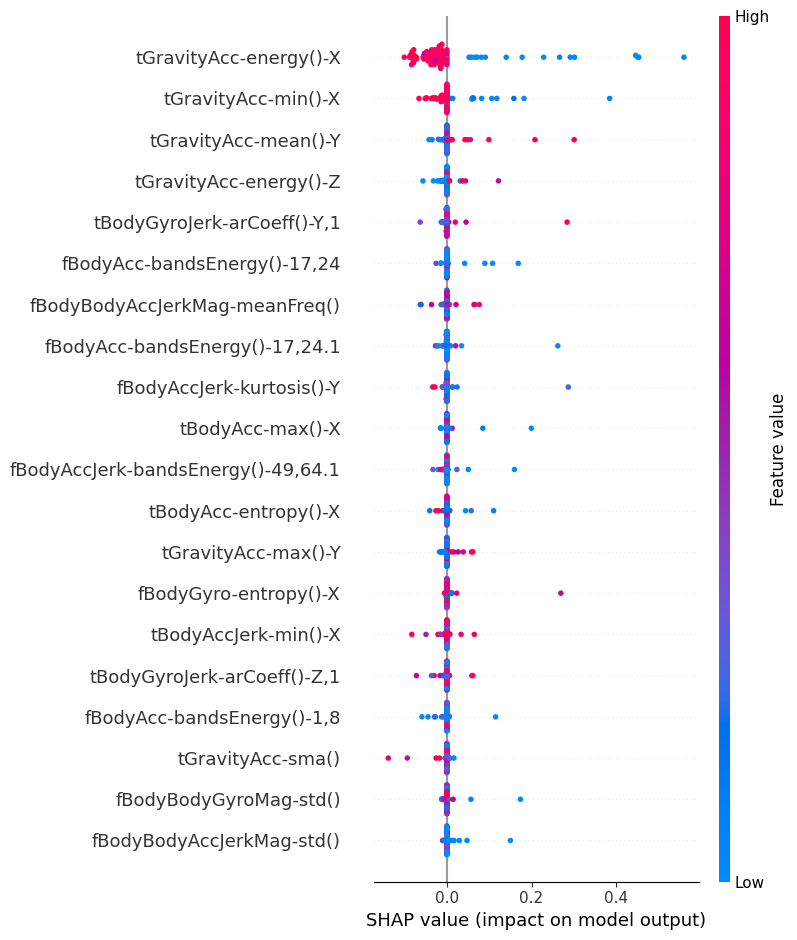

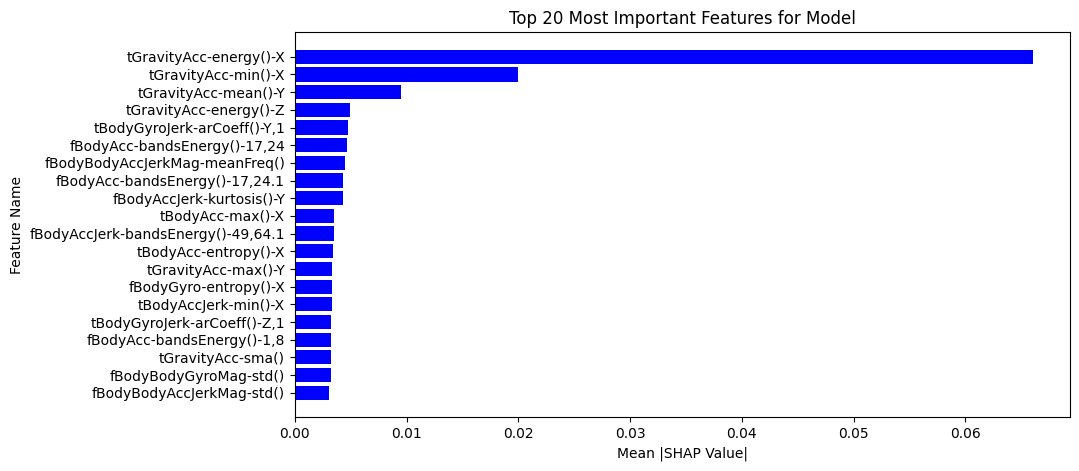

In [5]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Ensure correct input shape for SHAP
X_test_2d = X_test.squeeze(axis=-1)  # Convert from (samples, features, 1) → (samples, features)

# Define SHAP prediction function
def model_predict(X):
    X = np.expand_dims(X, axis=-1)  # Convert back to (samples, features, 1)
    return best_model.predict(X).astype(np.float64)

# Use a small subset of training data as background for SHAP
background = X_train.squeeze(axis=-1)[:50]  # Use only 50 background samples

# Initialize SHAP KernelExplainer
explainer = shap.KernelExplainer(model_predict, background)

# Compute SHAP values for 100 test samples
shap_values = explainer.shap_values(X_test_2d[:100], nsamples=100)

# Select SHAP values for a specific class (e.g., class 0)
shap_values_class = shap_values[0]  # Change index if needed for another class

# Compute mean absolute SHAP values for feature ranking
mean_shap_values = np.mean(np.abs(shap_values_class), axis=0)  # Mean over samples

# Get top 20 most important features
top_20_indices = np.argsort(mean_shap_values)[-20:][::-1]  # Get indices of top 20 features
top_20_features = selected_features[top_20_indices]  # Use feature names
top_20_importance = mean_shap_values[top_20_indices]  # Get importance values

# Print Top 20 Features and Their Importance
print("\n🔹 Top 20 Most Important Features:")
for i, (feature, importance) in enumerate(zip(top_20_features, top_20_importance), 1):
    print(f"{i}. {feature}: {importance:.5f}")

# === SHAP Visualizations ===

# 1️⃣ Summary Plot - Feature importance for one class
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_class, X_test_2d[:100], feature_names=selected_features)

# 2️⃣ Bar Chart of Top 20 Features
plt.figure(figsize=(10, 5))
plt.barh(top_20_features[::-1], top_20_importance[::-1], color="blue")
plt.xlabel("Mean |SHAP Value|")
plt.ylabel("Feature Name")
plt.title("Top 20 Most Important Features for Model")
plt.show()


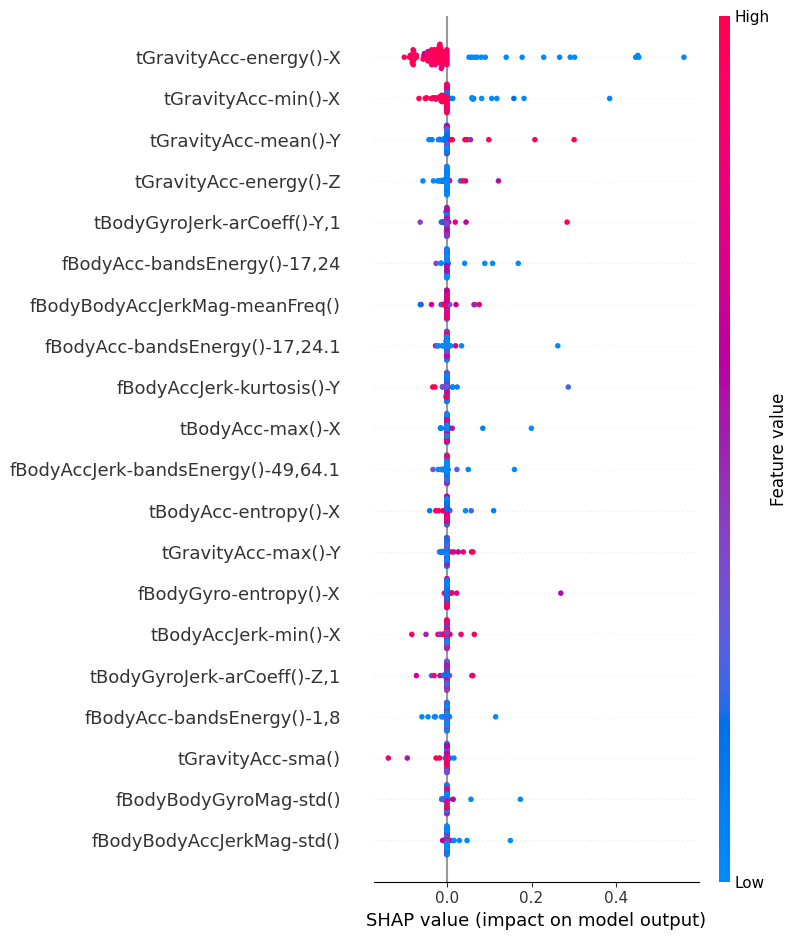

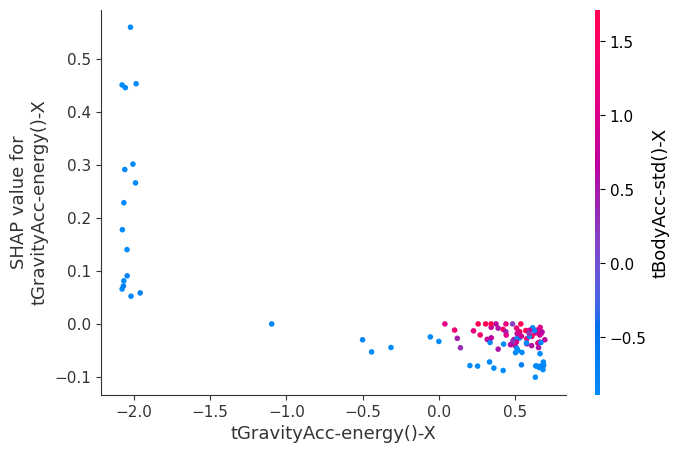

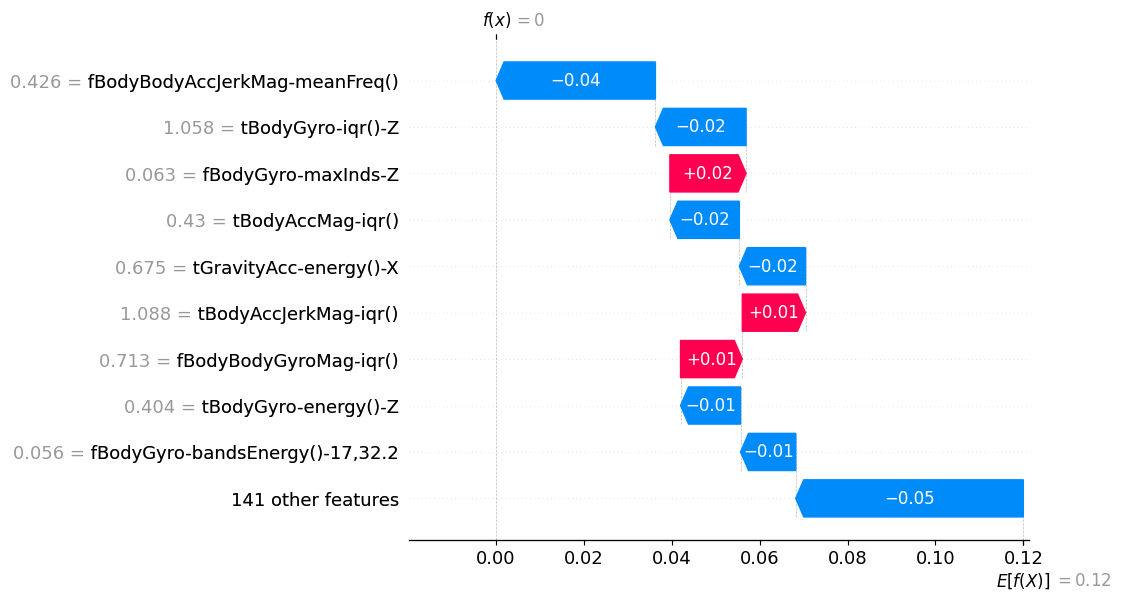

In [6]:
import shap
import matplotlib.pyplot as plt

# Ensure SHAP values are computed
shap_values_class = shap_values[0]  # Select SHAP values for class 0

# === 1️⃣ Beeswarm Plot (Alternative to Summary Plot) ===
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_class, X_test_2d[:100], feature_names=selected_features)

# === 2️⃣ Dependence Plot (Feature Interaction Effects) ===
# Select an important feature (e.g., the most important feature)
feature_to_plot = top_20_indices[0]  # Change index for different feature
shap.dependence_plot(feature_to_plot, shap_values_class, X_test_2d[:100], feature_names=selected_features)

# === 3️⃣ Waterfall Plot (SHAP Contribution Breakdown for One Sample) ===
sample_idx = 0  # Choose a test sample index
shap.plots.waterfall(shap.Explanation(
    values=shap_values_class[sample_idx], 
    base_values=explainer.expected_value[0], 
    data=X_test_2d[sample_idx], 
    feature_names=selected_features
))

plt.show()
